# **Importing Libraries****

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
#import tensorflow_datasets as tfdf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

# **Importing dataset**

In [4]:
BATCH_SIZE = 32
batch_size_ = BATCH_SIZE
img_height = 224
img_width = 224
CHANNEL = 3
data_dir = r"../data"
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size_)

Found 1835 files belonging to 30 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Ficus Auriculata (Roxburgh fig)', 'Ficus Religiosa (Peepal Tree)', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Pongamia Pinnata (Indian Beech)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)', 'Santalum Album (Sandalwood)', 'Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Trigonella Foenum-graecum (Fenugreek)']


# **Plotting Images for Visualization****

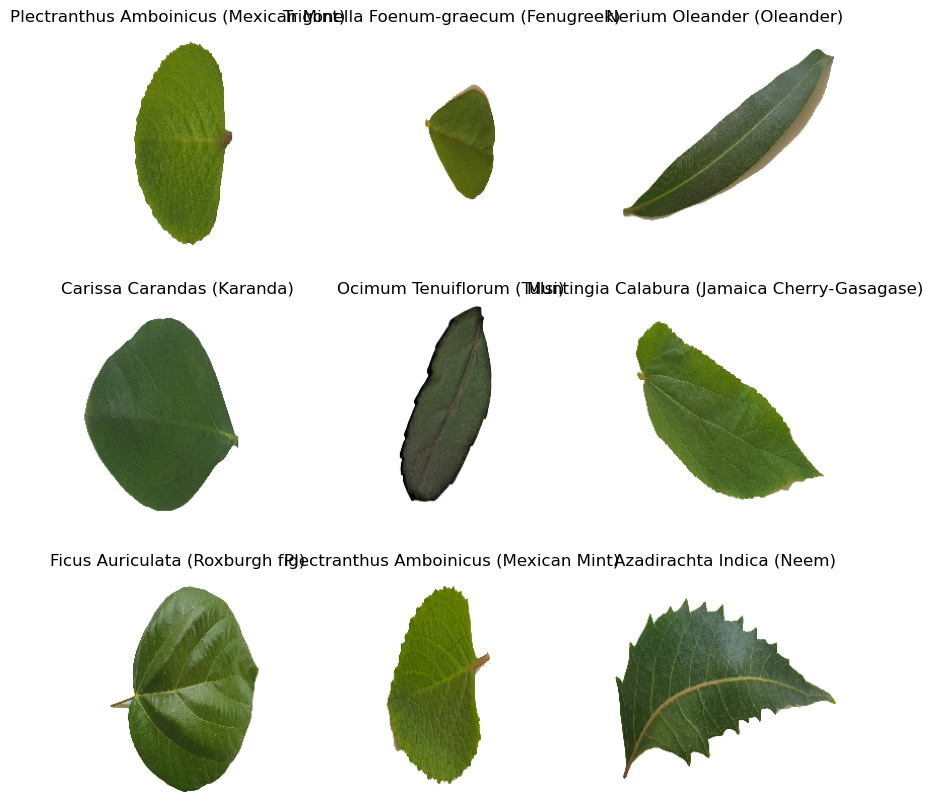

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Train Test Split****

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [10]:
# resizing images layer, later will be added in the model
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_height),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# **Augmentation****

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.3),
])

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

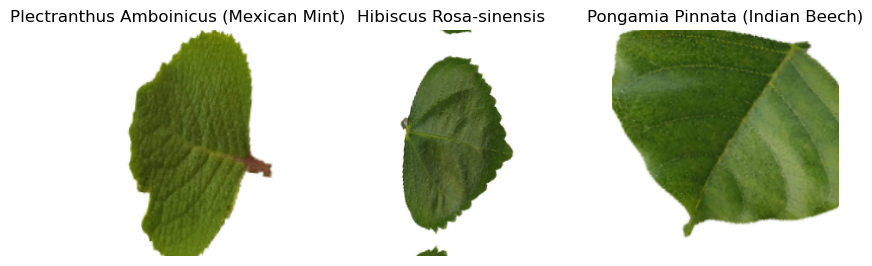

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Importing VGG19 for transfer learning

In [14]:
from tensorflow.keras.applications import VGG16

feature_extractor = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")



In [15]:
# make sure that layers are not trainable, that is weights of the vgg19 model will not change and we can use it as a feature extractor for our model
for layer in feature_extractor.layers:
    layer.trainable=False

# **Code below is commented,it is for the learning rate, can be used for some experimentation****

# **Defining the model layers**


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = keras.Sequential([
        resize_and_rescale,
        layers.BatchNormalization(),
        feature_extractor,
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(80, activation = 'softmax')
        ])



model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
model.build(input_shape = (None, 224, 224,3))

# **callback for earlystopping(really helpful for saving time and preventing the model from overfitting)****

In [20]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max' ,
                              patience = 7,
                              verbose = 1)


callback_list = [earlystopping]

In [22]:
model_history=model.fit(train_ds,
                        validation_data=val_ds,
                        epochs = 5,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/5
40/40 [==============================] - 498s 12s/step - loss: 0.7382 - accuracy: 0.7776 - val_loss: 1.6927 - val_accuracy: 0.6523
Epoch 2/5
40/40 [==============================] - 490s 12s/step - loss: 0.5079 - accuracy: 0.8459 - val_loss: 1.2318 - val_accuracy: 0.6914
Epoch 3/5
40/40 [==============================] - 510s 13s/step - loss: 0.3673 - accuracy: 0.8793 - val_loss: 0.9125 - val_accuracy: 0.7461
Epoch 4/5
40/40 [==============================] - 558s 14s/step - loss: 0.2846 - accuracy: 0.9095 - val_loss: 0.5274 - val_accuracy: 0.8711
Epoch 5/5
40/40 [==============================] - 577s 14s/step - loss: 0.2306 - accuracy: 0.9214 - val_loss: 0.3546 - val_accuracy: 0.9141


In [23]:
from tensorflow.keras.models import save_model
save_model(model, '../models/vgg.h5')